# Countermeasures model v1

Changes:
* Fixed convolution by creating a tested library version
* Cleared up import code, removed obsolete mask, added text cells
* Improve plotting & writeouts
* Renamed from "basic" to v1 (this is hardly a simple model)
* Use exp(-gamma) as CMReduction prior
* Use Active in place of Confirmed for exp growth
* Transform to log space (much more stable!)
* Use Half-cauchy hyperprior for DailyGrowth variance
* Use more countries (from model description doc)
* Update to `countermeasures-model-boolean_Gat3Bus2SchCurHespMa.csv` features
* Update countries to Jan Brauner's rec. [here](https://epidemicforecasting.slack.com/archives/C010KK204TG/p1587753717310600) (minus JK's comments)
* Change the model to a SEICRD model, C=convalescence

## Import & initialization

In [1]:
### Initial imports
%load_ext autoreload
%autoreload 2

import datetime
import io
import logging
from pathlib import Path

import dateutil
import datetime
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 10]

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel import RegionDataset, read_csv, Level
from epimodel.pymc3_models.utils import geom_convolution, convolution
from epimodel.pymc3_models import cm_effect

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Loading data and parameter settings

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.



Countermeasures                            min   .. mean  .. max
 0 Gatherings limited to 10                   0.000 .. 0.281 .. 1.000  [0.0, 1.0]
 1 Gatherings limited to 100                  0.000 .. 0.494 .. 1.000  [0.0, 1.0]
 2 Gatherings limited to 1000                 0.000 .. 0.557 .. 1.000  [0.0, 1.0]
 3 Business suspended - some                  0.000 .. 0.541 .. 1.000  [0.0, 1.0]
 4 Business suspended - many                  0.000 .. 0.407 .. 1.000  [0.0, 1.0]
 5 Schools and universities closed            0.000 .. 0.679 .. 1.000  [0.0, 1.0]
 6 General curfew                             0.000 .. 0.287 .. 1.000  [0.0, 1.0]
 7 Healthcare specialisation                  0.000 .. 0.095 .. 1.000  [0.0, 1.0]
 8 Mask wearing over 70%                      0.000 .. 0.095 .. 1.000  [0.0, 1.0]

Countermeasures                            min   .. mean  .. max
 0 Gatherings limited to 10                   0.000 .. 0.391 .. 1.000  [0.0, 1.0]
 1 Gatherings limited to 100                  0.

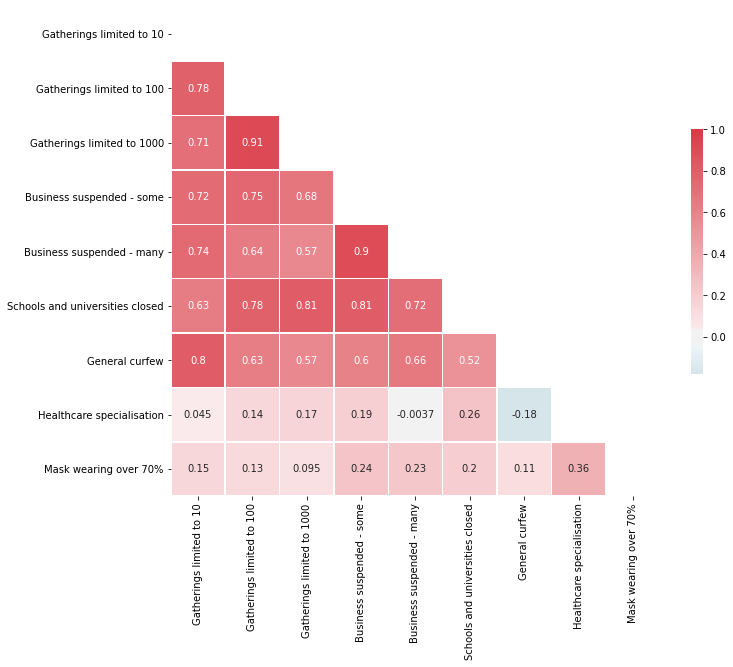

In [2]:
# From https://epidemicforecasting.slack.com/archives/C010KK204TG/p1587753717310600
# Removing by JK recommendation

Cs = ['AD', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'ES', 
      'FI', 'GB', 'GR', 'HR', 'HU', 'IE', 'IL', 'IS', 'IT',
      'LT', 'MA', 'MX', 'NL', 'PL', 'RO', 'RS', 'SE', 'SG', 'SI',
      'SK', 'ZA']
## Note: leaving out 'MY' since it has no data
## Note: leaving out 'FR' for large jumps, 'EE' too
nCs = len(Cs)

CMs = ["Gatherings limited to 10", "Gatherings limited to 100", "Gatherings limited to 1000",
       "Business suspended - some", "Business suspended - many",
       "Schools and universities closed", "General curfew",
       "Healthcare specialisation", "Mask wearing over 70%"]
nCMs = len(CMs)

data = cm_effect.Loader('2020-02-25', '2020-04-15', Cs, CMs, active_cm_file='countermeasures-model-boolean_Gat3Bus2SchCurHespMa.csv')
data.print_stats()

Ds = data.Ds
nDs = len(data.Ds)

# [country, day]
Confirmed = data.Confirmed
Recovered = data.Recovered
Active = data.Active
Deaths = data.Deaths
NewConfirmed = data.NewConfirmed
NewDeaths = data.NewDeaths

# [country]
Population = data.Population

# [country, CM, day]
ActiveCMs = data.ActiveCMs

# Fixing any ActiveCMs inconsistiences
def CM_implies_CM(cma, cmb):
    ActiveCMs[:, CMs.index(cmb), :] = np.maximum(ActiveCMs[:, CMs.index(cma), :], ActiveCMs[:, CMs.index(cmb), :])
CM_implies_CM("General curfew", "Gatherings limited to 10")
CM_implies_CM("Gatherings limited to 10", "Gatherings limited to 100")
CM_implies_CM("Gatherings limited to 100", "Gatherings limited to 1000")
CM_implies_CM("General curfew", "Schools and universities closed")
CM_implies_CM("General curfew", "Business suspended - many")
CM_implies_CM("Business suspended - many", "Business suspended - some")
data.print_stats(ActiveCMs)

def statstr(d):
    return f"{d.mean():.3g} ({np.quantile(d, 0.05):.3g} .. {np.quantile(d, 0.95):.3g})"

def plot_CM_correlation(CMs, ActiveCMs, DelayProb):
    dcs = {}
    for cmi, cm in enumerate(CMs):
        dcs[cm] = []
        for ci in range(nCs):
            dcs[cm].extend(np.convolve(ActiveCMs[ci, cmi, :], DelayProb))
    dcs = pd.DataFrame(dcs)
    corr = dcs.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, center=0, annot=True,
                square=True, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5})

_DelayProb = np.array([0.00, 0.01, 0.02, 0.06, 0.10, 0.13, 0.15, 0.15, 0.13, 0.10, 0.07, 0.05, 0.03])
plot_CM_correlation(CMs, ActiveCMs, _DelayProb)


## Model definition

In [64]:
def create_SEICRD_computation():
    InitialS = T.vector("InitialS")
    InitialE = T.vector("InitialE")
    InitialI = T.vector("InitialI")
    InitialCI = T.vector("InitialCI")
    InitialC = T.vector("InitialC")
    InitialR = T.vector("InitialR")
    InitialD = T.vector("InitialD")
    DailyBeta = T.matrix("DailyBeta")

    def SEICRD_step(Beta_t, S_tm1, E_tm1, I_tm1, CI_tm1, C_tm1, R_tm1, D_tm1):
        S2E = Beta_t * S_tm1 * I_tm1 / Population
        E2I = EtoI * E_tm1
        I2C = ItoC * I_tm1
        I2D = ItoD * I_tm1
        C2R = CtoR * C_tm1
        C2D = CtoD * C_tm1
        S_t = S_tm1 - S2E
        E_t = E_tm1 + S2E - E2I
        I_t = I_tm1 + E2I - I2C - I2D
        CI_t = CI_tm1 + E2I
        C_t = C_tm1 + I2C - C2R
        R_t = R_tm1 + C2R
        D_t = D_tm1 + I2D + C2D
        return S_t, E_t, I_t, CI_t, C_t, R_t, D_t
        
    (S, E, I, CI, C, R, D), updates = theano.scan(
        SEICRD_step,
        sequences = [pm.math.exp(DailyBeta)],
        outputs_info = [InitialS, InitialE, InitialI, InitialCI, InitialC, InitialR, InitialD])

    return theano.function(
        [DailyBeta, InitialS, InitialE, InitialI, InitialCI, InitialC, InitialR, InitialD],
        [S, E, I, CI, C, R, D],
        mode='FAST_RUN',
        updates=updates
    )

# SEICRD_computation = create_SEICRD_computation()

In [3]:
## !!! Many (but not all) variables below are in Log-space !!!!

with pm.Model() as model:
    
    # Parameters - not in lospace
    S_fraction = 0.8
    EtoI = np.full((nCs, nDs), 0.2)
    ItoC = np.full((nCs, nDs), 0.5)
    ItoD = np.full((nCs, nDs), 0.0)
    CtoR = np.full((nCs, nDs), 1 / 14)
    #CtoR = pm.Lognormal("CtoR", np.log(0.05), np.log(1.02), shape=(nCs, nDs))
    CtoD = np.full((nCs, nDs), 1 / 100 / 14)

    # [country] Country growth rate
    # TODO: Estimate growth rate variance
    CountryBeta0 = pm.Normal("CountryBeta0", np.log(1.285), 0.05, shape=(nCs,))
    CountryBeta0_Plain = pm.Deterministic("CountryBeta0_Plain", pm.math.exp(CountryBeta0))
    
    # [CM] How much countermeasures reduce growth rate
    # TODO: Possibly use another distribution
    CMReductionGamma = pm.Gamma("CMReductionGamma", 0.5, 1.0, shape=(nCMs,))
    CMReduction = pm.Deterministic("CMReduction", T.exp((-1.0) * CMReductionGamma))
    # [country, CM, day] Reduction factor for each CM,C,D
    ActiveCMReduction = T.reshape(CMReductionGamma, (1, nCMs, 1)) * ActiveCMs
    # [country, day + CMDelayCut] Reduction factor from CMs for each C,D (noise added below)
    BetaReduction = pm.Deterministic("BetaReduction", T.sum(ActiveCMReduction, axis=1))

    # [country, day] The ideal predicted daily growth
    PredictedDailyBeta = pm.Deterministic("PredictedDailyBeta",
        T.reshape(CountryBeta0, (nCs, 1)) - BetaReduction)
    
    # [country, day] The actual (still hidden) growth each day
    # TODO: Estimate noise varince (should be small, measurement variance below)
    #       Miscalibration: too low: time effects pushed into CMs, too high: explains away CMs
    DailyBeta = pm.Normal("DailyBeta", PredictedDailyBeta, 0.1, shape=(nCs, nDs))
    
    # The following section is NOT in log-space
    
    InitialE = pm.Lognormal("InitialE", 0.0, 10.0, shape=(nCs, ))
    InitialI = pm.Lognormal("InitialI", 0.0, 10.0, shape=(nCs, ))
    InitialCumI = pm.Lognormal("InitialCumI", 0.0, 10.0, shape=(nCs, ))
    InitialC = pm.Lognormal("InitialC", 0.0, 10.0, shape=(nCs, ))
    InitialR = pm.Lognormal("InitialR", 0.0, 10.0, shape=(nCs, ))
    InitialD = pm.Lognormal("InitialD", 0.0, 10.0, shape=(nCs, ))
    InitialS = Population * S_fraction #- InitialE - InitialI - InitialC - InitialR - InitialD

    def SEICRD_step(Beta_t,  EtoI_t, ItoC_t, ItoD_t, CtoR_t, CtoD_t, S_tm1, E_tm1, I_tm1, CumI_tm1, C_tm1, R_tm1, D_tm1):
        S2E = Beta_t * S_tm1 * I_tm1 / Population
        E2I = EtoI_t * E_tm1
        I2C = ItoC_t * I_tm1
        I2D = ItoD_t * I_tm1
        C2R = CtoR_t * C_tm1
        C2D = CtoD_t * C_tm1
        S_t = S_tm1 - S2E
        E_t = E_tm1 + S2E - E2I
        I_t = I_tm1 + E2I - I2C - I2D
        CumI_t = CumI_tm1 + E2I
        C_t = C_tm1 + I2C - C2R
        R_t = R_tm1 + C2R
        D_t = D_tm1 + I2D + C2D
        return S_t, E_t, I_t, CumI_t, C_t, R_t, D_t
        
    outs, _ = theano.scan(
        SEICRD_step,
        sequences = [T.as_tensor(v) for v in [pm.math.exp(DailyBeta.T), EtoI.T, ItoC.T, ItoD.T, CtoR.T, CtoD.T]],
        outputs_info = [InitialS, InitialE, InitialI, InitialCumI, InitialC, InitialR, InitialD])

    # To logspace again!
    V = {}
    for n, val in zip(("S", "E", "I", "CumI", "C", "R", "D"), outs):
         V[n] = pm.math.log(pm.Deterministic(n, val.T))
    
    #ObsConfirmed = pm.Normal("ObsConfirmed", V["CumI"], np.log(1.3), shape=(nCs, nDs), observed=np.log(Confirmed))
    #ObsRecovered = pm.Normal("ObsRecovered", V["R"], np.log(1.1), shape=(nCs, nDs), observed=np.log(Recovered))
    ObsDeaths = pm.Normal("ObsDeaths", V["D"], np.log(1.1), shape=(nCs, nDs), observed=np.log(Deaths))    

INFO (theano.gof.compilelock): Waiting for existing lock by process '12178' (I am process '13628')
INFO:theano.gof.compilelock:Waiting for existing lock by process '12178' (I am process '13628')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/gavento/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /home/gavento/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir
/home/gavento/proj/epimodel/.venv/lib/python3.6/site-packages/pymc3/model.py:1430: ImputationWarning: Data in ObsDeaths contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


## Run MCMC inference

1000 steps is enough for seeing the convergence and rough results, more is better, though.

In [9]:
print(model.check_test_point())
with model:
    trace = pm.sample(1000, chains=2, cores=2, init='adapt_diag', tune=500)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CountryBeta0                  64.38
CMReductionGamma_log__       -12.77
DailyBeta                   2187.55
InitialE_log__               -99.87
InitialI_log__               -99.87
InitialCumI_log__            -99.87
InitialC_log__               -99.87
InitialR_log__               -99.87
InitialD_log__               -99.87
ObsDeaths_missing              0.00
ObsDeaths                -995725.70
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ObsDeaths_missing, InitialD, InitialR, InitialC, InitialCumI, InitialI, InitialE, DailyBeta, CMReductionGamma, CountryBeta0]
INFO:pymc3:NUTS: [ObsDeaths_missing, InitialD, InitialR, InitialC, InitialCumI, InitialI, InitialE, DailyBeta, CMReductionGamma, CountryBeta0]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [43:59<00:00,  1.14draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samp

## Plot chain stability

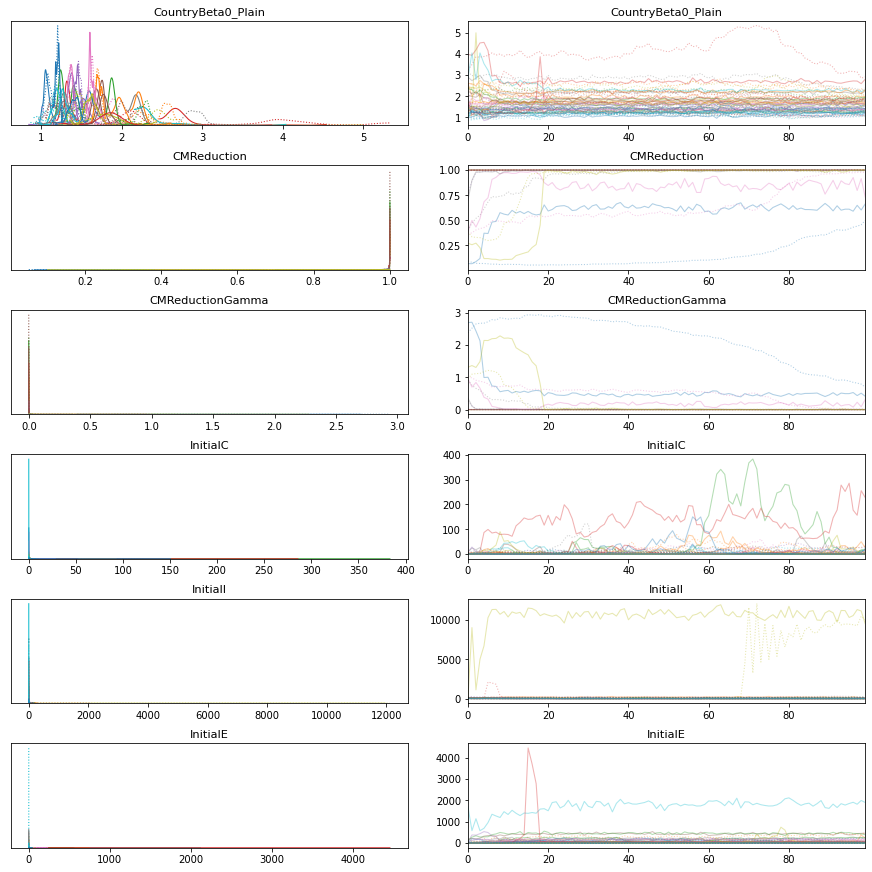

In [5]:
_ = pm.traceplot(trace, var_names=["CountryBeta0_Plain", "CMReduction", "CMReductionGamma", "InitialC", "InitialI", "InitialE"])

## Plot inferred countermeasure effect

Effects are multiplicative (e.g. for a countermeasure that is a strenghtening of another, the inferred strenght is the additional multiplier).

The countermeasure strength is the multiplicative effect at feature=1.0.

 0 Gatherings limited to 10                 CMReduction 0.368 (0.0565 .. 0.656)
 1 Gatherings limited to 100                CMReduction 1 (0.998 .. 1)
 2 Gatherings limited to 1000               CMReduction 1 (0.999 .. 1)
 3 Business suspended - some                CMReduction 0.999 (0.998 .. 1)
 4 Business suspended - many                CMReduction 0.996 (0.99 .. 1)
 5 Schools and universities closed          CMReduction 1 (0.999 .. 1)
 6 General curfew                           CMReduction 0.74 (0.481 .. 0.974)
 7 Healthcare specialisation                CMReduction 0.963 (0.747 .. 1)
 8 Mask wearing over 70%                    CMReduction 0.871 (0.172 .. 1)


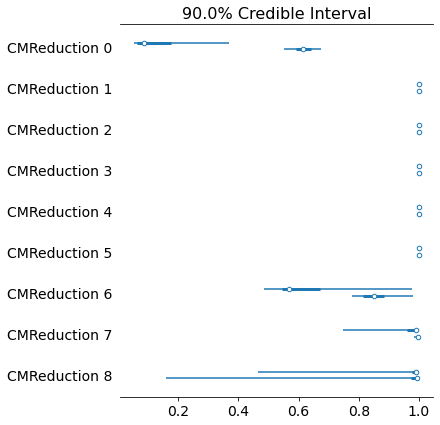

In [6]:
pm.forestplot(trace, var_names=['CMReduction'], credible_interval=0.9)
for i, c in enumerate(CMs):
    print(f"{i:2} {c:40} CMReduction {statstr(trace['CMReduction'][:,i])}")

Cummulated CM effects
 0 Gatherings limited to 10                 CMReductionC 0.368 (0.0565 .. 0.654)
 1 Gatherings limited to 100                CMReductionC 0.999 (0.998 .. 1)
 2 Gatherings limited to 1000               CMReductionC 1 (0.999 .. 1)
 3 Business suspended - some                CMReductionC 0.999 (0.998 .. 1)
 4 Business suspended - many                CMReductionC 0.996 (0.99 .. 1)
 5 Schools and universities closed          CMReductionC 1 (0.999 .. 1)
 6 General curfew                           CMReductionC 0.74 (0.481 .. 0.974)
 7 Healthcare specialisation                CMReductionC 0.963 (0.747 .. 1)
 8 Mask wearing over 70%                    CMReductionC 0.871 (0.172 .. 1)


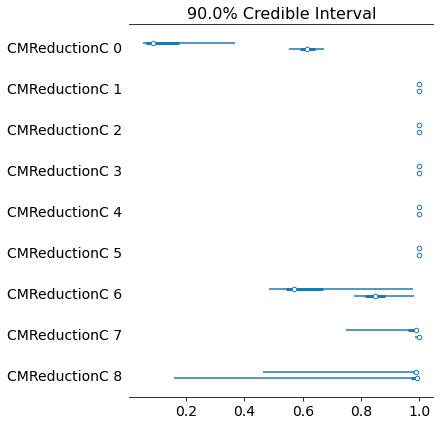

In [7]:
print("Cummulated CM effects")

a = trace['CMReduction']
def add_CM_to_CM(a, src, tgt):
    a[:, CMs.index(tgt)] *= a[:, CMs.index(src)]
add_CM_to_CM(a, "Gatherings limited to 1000", "Gatherings limited to 100")
add_CM_to_CM(a, "Gatherings limited to 100", "Gatherings limited to 10")
add_CM_to_CM(a, "Business suspended - some", "Business suspended - many")
trace.add_values({'CMReductionC': a}, True)

pm.forestplot(trace, var_names=['CMReductionC'], credible_interval=0.9)
for i, c in enumerate(CMs):
    print(f"{i:2} {c:40} CMReductionC {statstr(trace['CMReductionC'][:,i])}")

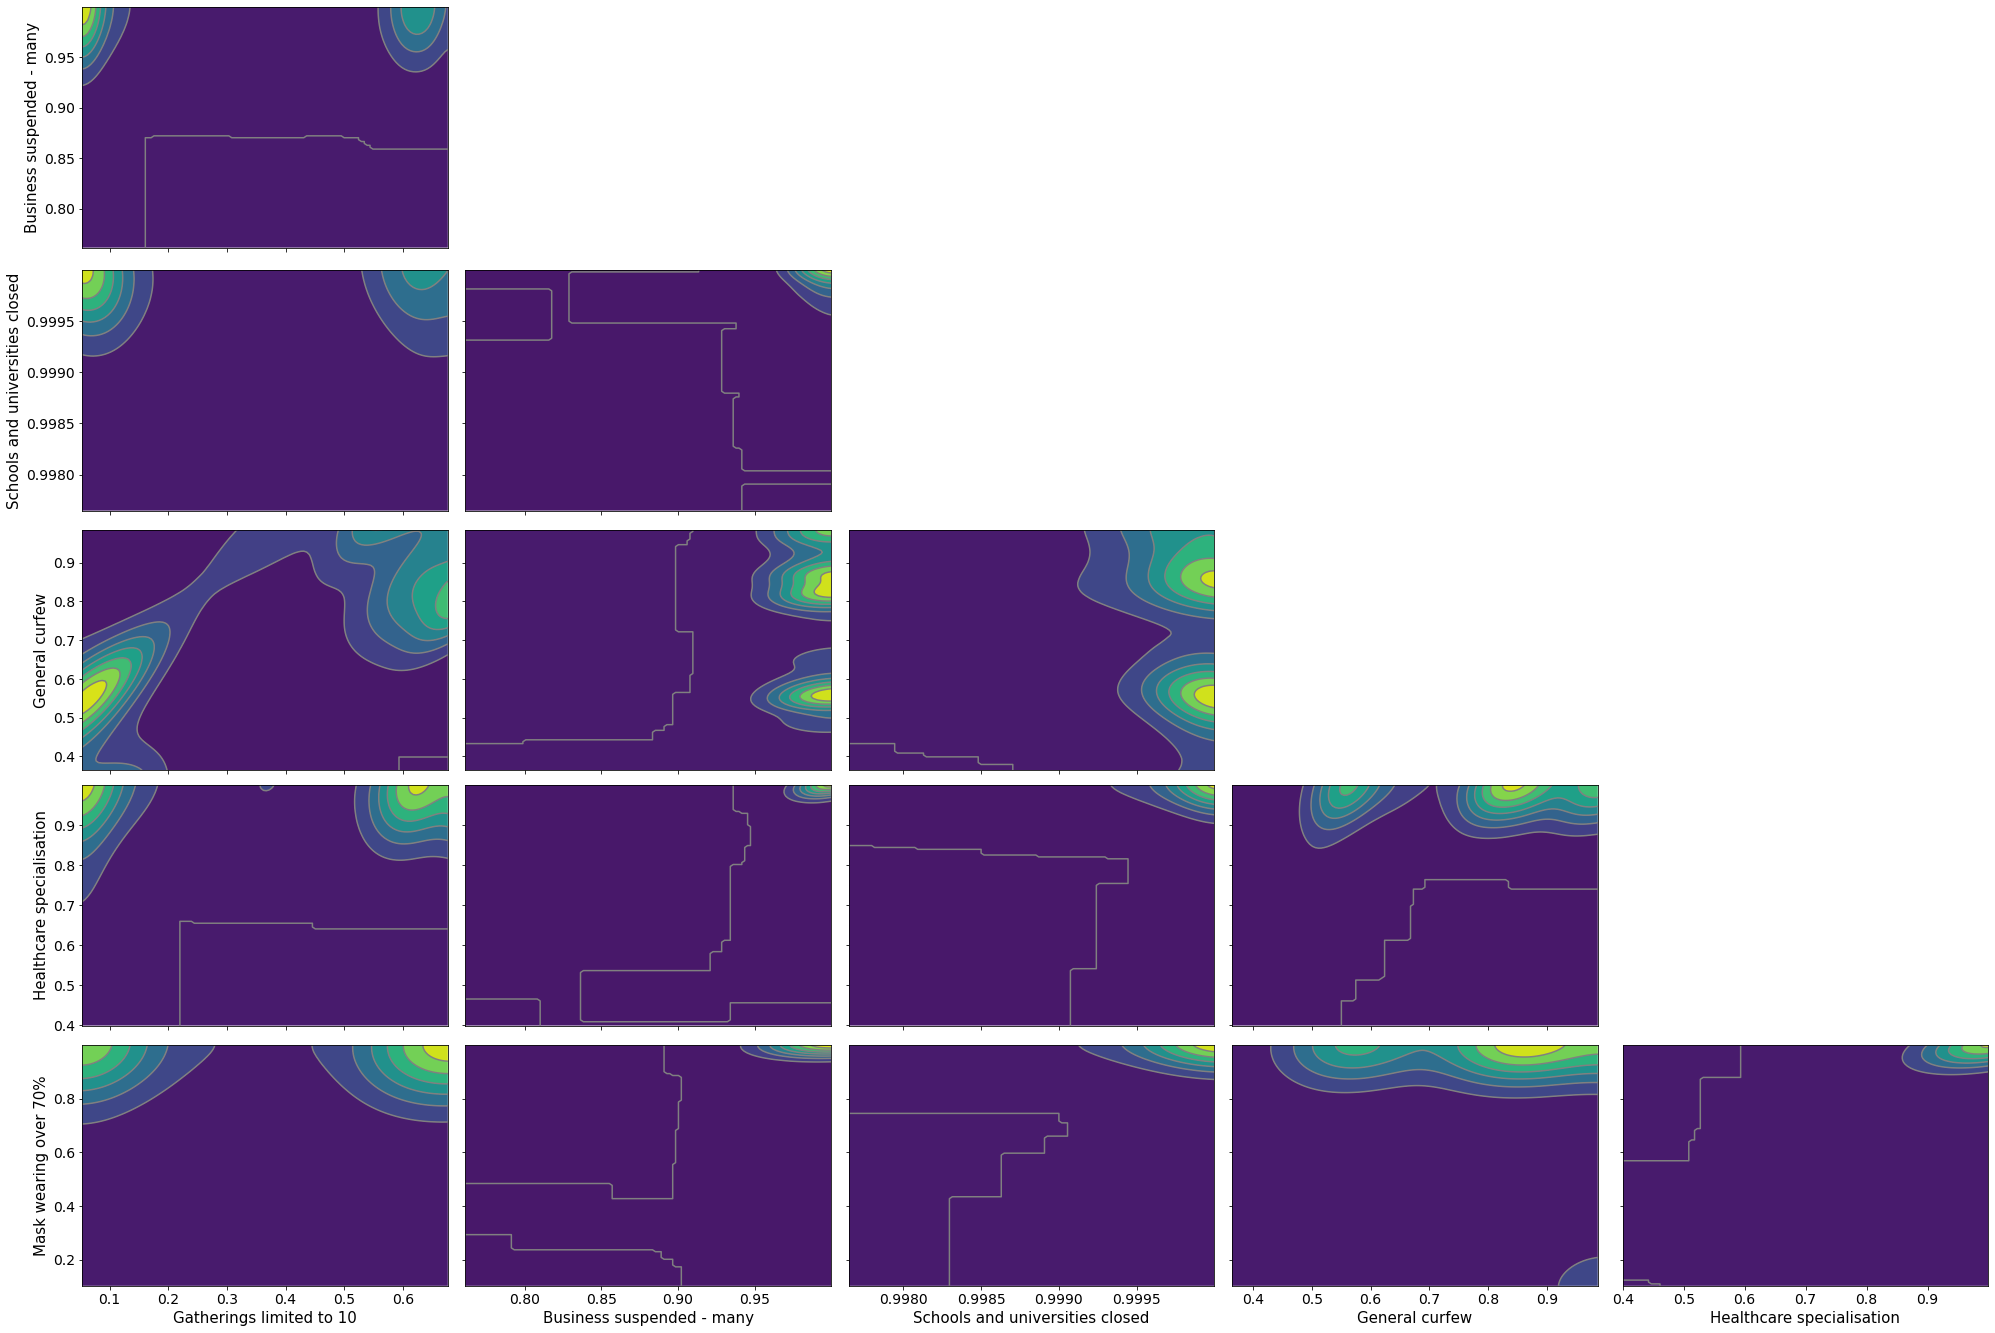

In [8]:
vs = []
for vn in ["Gatherings limited to 10", "Business suspended - many",
       "Schools and universities closed", "General curfew",
       "Healthcare specialisation", "Mask wearing over 70%"]:
    i = CMs.index(vn)
    vs.append(vn)
    trace.add_values({vn: trace['CMReductionC'][:, i]}, True)
_ = pm.plots.pairplot(trace, var_names=vs, kind='kde')

## Predicting number of deaths (log of predicted/actual ratio)

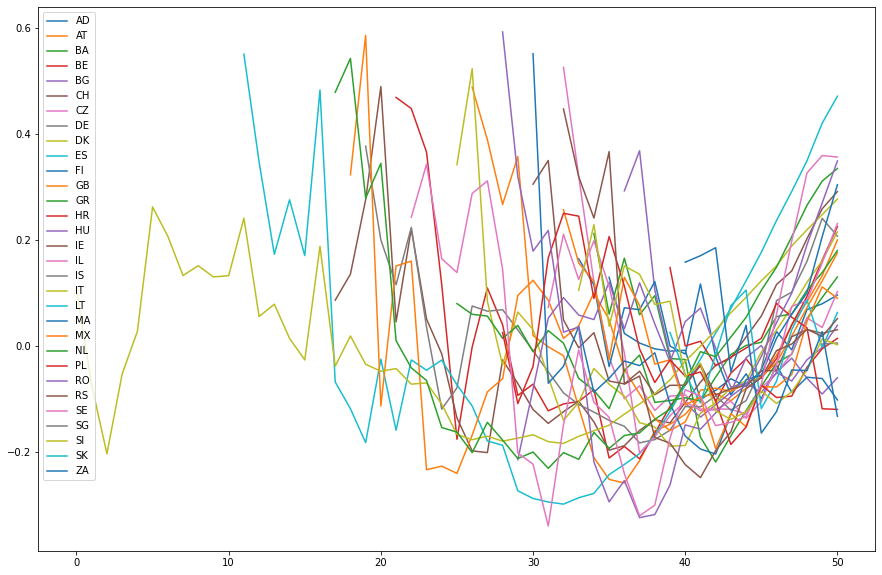

In [44]:
_=plt.plot(np.log(trace['D'].mean(axis=0) / Deaths.filled(np.nan)).T)
_=plt.legend(Cs)

## Beta (before and after noise)

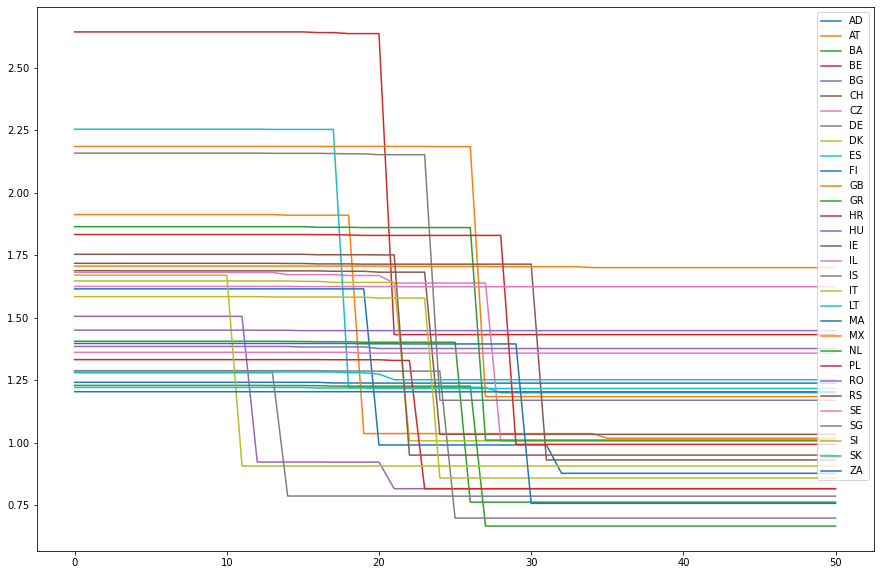

In [43]:
_=plt.plot(np.exp(trace['PredictedDailyBeta']).mean(axis=0).T)
_=plt.legend(Cs)

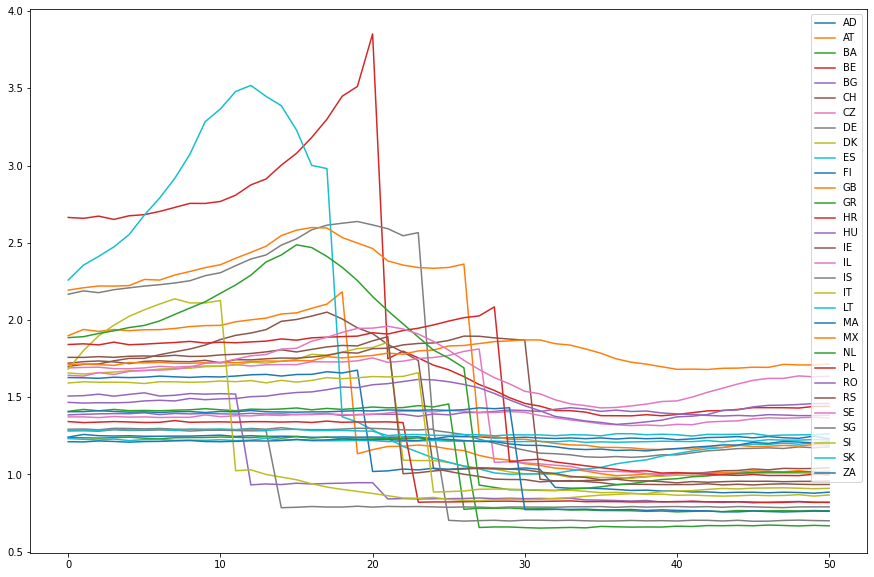

In [42]:
_=plt.plot(np.exp(trace['DailyBeta']).mean(axis=0).T)
_=plt.legend(Cs)

## Predicting number of confirmed (log of predicted/actual ratio) - not observed

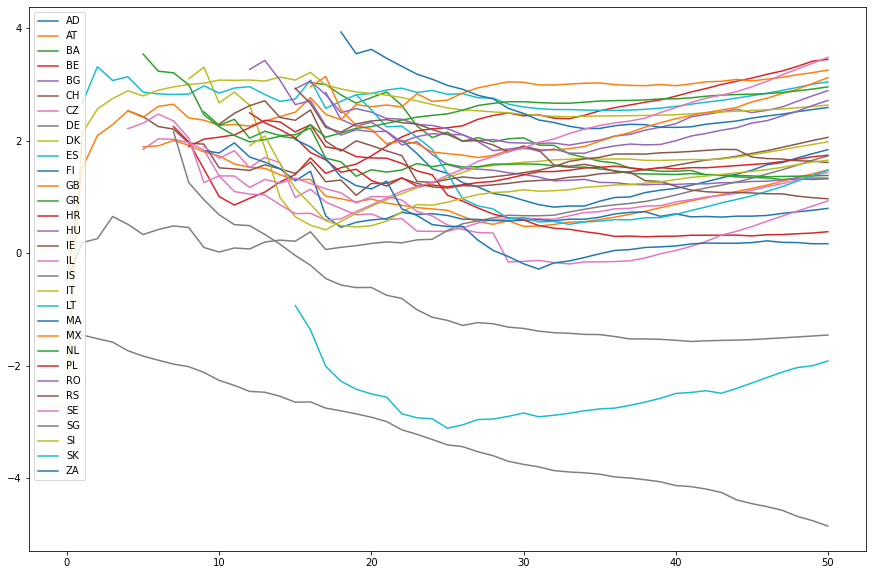

In [41]:
_=plt.plot(np.log(trace['C'].mean(axis=0) / Confirmed.filled(np.nan)).T)
_=plt.legend(Cs)

## Infectious compartment (log_10)

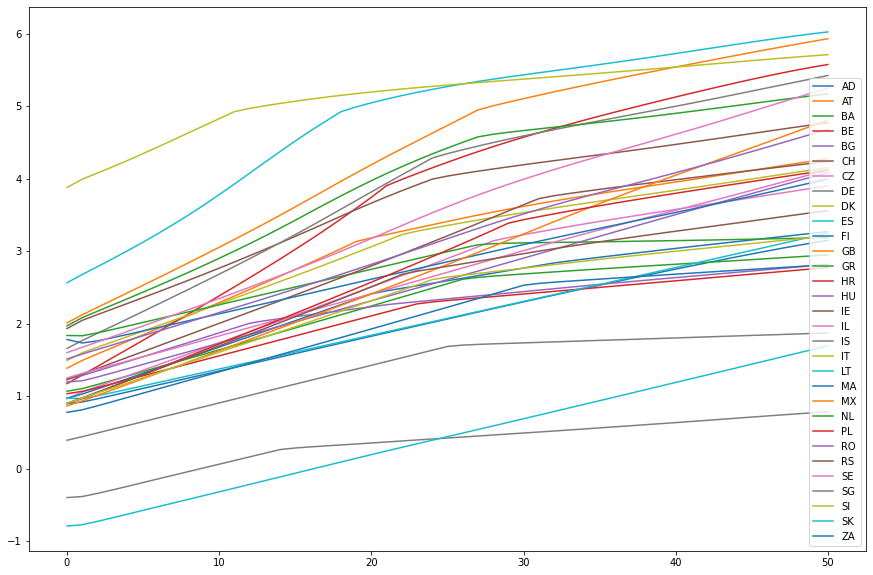

In [46]:
_=plt.plot(np.log10(trace['I'].mean(axis=0).T))
_=plt.legend(Cs)

In [22]:
import plotly
from plotly import graph_objects as go
import plotly.express as px
import datetime
#plotly.offline.init_notebook_mode(connected=True)
plotly.io.orca.config.executable = "/home/gavento/.local/bin/orca"
from IPython.display import Image

def plot_line_CIs(fig, x, ys, name, color, quantiles=(0.05, 0.25), opacities=(0.1, 0.15)):
    ys = np.minimum(ys, 1e10)
    x=list(x)
    fig.add_trace(go.Scatter(
        x=x,
        y=list(ys.mean(axis=0)),
        name=name, legendgroup=name, line_color=color
    ))    
    for q, o in zip(quantiles, opacities):
        ylo = list(np.quantile(ys, q, axis=0))
        yhi = list(np.quantile(ys, 1.0-q, axis=0))
        fig.add_trace(go.Scatter(
            x=x + x[::-1],
            y=ylo+yhi[::-1],
            fill='toself',
            fillcolor=color,
            opacity=o,
            line_color='rgba(255,255,255,0)',
            showlegend=False,
            name=name, legendgroup=name,
        ))    
        
def plot_traces(data, save_name=None):
    fig = go.Figure()
    fig.layout.title = go.layout.Title(text=save_name)
    for i, c in enumerate(Cs):
        d = data[:,i,:]
        color = (px.colors.qualitative.Dark24 * 10)[i]
        plot_line_CIs(fig, Ds, d, c, color, quantiles=())
    if save_name:
        datestr = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        fname = f'plot_{datestr}_{save_name}.html'
        plotly.io.write_html(fig, fname, include_plotlyjs='cdn')
        print(f"Wrote {save_name} to {fname}")
    return fig

In [ ]:
plotly.offline.iplot(plot_traces(np.exp(trace['DailyBeta'])))

In [ ]:
plot_traces(np.exp(trace['PredictedDailyBeta']))

In [ ]:
plot_traces(np.log(trace['CumI'] / Confirmed.filled(np.nan)))

In [ ]:
plot_traces(np.log(trace['R'] / Recovered.filled(np.nan)))

In [ ]:
plot_traces(trace['E'], 'SEICRD_exposed')

In [ ]:
plot_traces(trace['I'], 'SEICRD_infectious')